In [1]:
# # # import the required libraries

# frequency based approach



import nltk
import sklearn
# # # punkt tokenizer for sentence tokenization
# nltk.download('punkt') 

# nltk.download('stopwords') 

from collections import Counter # Imports the Counter class from the collections module, used for counting the frequency of words in a text.
from nltk.corpus import stopwords # Imports the stop words list from the NLTK corpus
# corpus is a large collection of text or speech data used for statistical analysis

from nltk.tokenize import sent_tokenize, word_tokenize # Imports the sentence tokenizer and word tokenizer 

def generate_summaryfba(text, n):
   # Tokenize the text into individual sentences
   sentences = sent_tokenize(text)

   # Tokenize each sentence into individual words and remove stopwords
   stop_words = set(stopwords.words('english'))

   words = [word.lower() for word in word_tokenize(text) if word.lower() not in stop_words and word.isalnum()]

   # Compute the frequency of each word
   word_freq = Counter(words)


   sentence_scores = {}

   for sentence in sentences:
      sentence_words = [word.lower() for word in word_tokenize(sentence) if word.lower() not in stop_words and word.isalnum()]
      sentence_score = sum([word_freq[word] for word in sentence_words])
      if len(sentence_words) < 15:
         sentence_scores[sentence] = sentence_score

# # # checks if the length of the sentence_words list is less than 15 (parameter can be adjusted based on the desired length of summary sentences)
# # # If condition -> true, score of the current sentence is added to the sentence_scores dictionary with the sentence itself as the key
# # # This is to filter out very short sentences that may not provide meaningful information for summary generation

# # # Select the top n sentences with the highest scores
   summary_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)[:n]
   summary = ' '.join(summary_sentences)

   return summary

In [2]:
#Text Rank Algorithm

import re

import numpy as np
from nltk import sent_tokenize, word_tokenize

from nltk.cluster.util import cosine_distance

MULTIPLE_WHITESPACE_PATTERN = re.compile(r"\s+", re.UNICODE)

def _replace_whitespace(match):
    text = match.group()

    if "\n" in text or "\r" in text:
        return "\n"
    else:
        return " "

def normalize_whitespace(text):
    """
    Translates multiple whitespace into single space character.
    If there is at least one new line character chunk is replaced
    by single LF (Unix new line) character.
    """
    return MULTIPLE_WHITESPACE_PATTERN.sub(_replace_whitespace, text)

def symmetrize(a):
    """
    Return a symmetrized version of NumPy array a.

    Values 0 are replaced by the array value at the symmetric
    position (with respect to the diagonal), i.e. if a_ij = 0,
    then the returned array a' is such that a'_ij = a_ji.

    Diagonal values are left untouched.

    a -- square NumPy array, such that a_ij = 0 or a_ji = 0, 
    for i != j.
    """
    return a + a.T - np.diag(a.diagonal())





def core_cosine_similarity(vector1, vector2):
    """
    measure cosine similarity between two vectors
    :param vector1:
    :param vector2:
    :return: 0 < cosine similarity value < 1
    """
    return 1 - cosine_distance(vector1, vector2)





def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []

    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]

    all_words = list(set(sent1 + sent2))

    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)

    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1

    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1

    return core_cosine_similarity(vector1, vector2)





def build_similarity_matrix(sentences, stopwords=None):
    # create an empty similarity matrix
    sm = np.zeros([len(sentences), len(sentences)])

    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2:
                continue

            sm[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stopwords=stopwords)

    # Get Symmeric matrix
    sm = symmetrize(sm)

    # Normalize matrix by column
    norm = np.sum(sm, axis=0)
    sm_norm = np.divide(sm, norm, where=norm != 0)  # this is to ignore the 0 element in norm

    return sm_norm




def run_page_rank(similarity_matrix):

    # constants
    damping = 0.85  # damping coefficient, usually is .85
    min_diff = 1e-5  # convergence threshold
    steps = 100  # iteration steps

    pr_vector = np.array([1] * len(similarity_matrix))

    # Iteration
    previous_pr = 0
    for epoch in range(steps):
        pr_vector = (1 - damping) + damping * np.matmul(similarity_matrix, pr_vector)
        if abs(previous_pr - sum(pr_vector)) < min_diff:
            break
        else:
            previous_pr = sum(pr_vector)

    return pr_vector

def get_top_sentences(pr_vector, sentences, number=3):

    top_sentences = []

    if pr_vector is not None:

        sorted_pr = np.argsort(pr_vector)
        sorted_pr = list(sorted_pr)
        sorted_pr.reverse()

        index = 0
        for epoch in range(number):
            sent = sentences[sorted_pr[index]]
            sent = normalize_whitespace(sent)
            top_sentences.append(sent)
            index += 1

    return top_sentences



def generateTextRank(text_str):
  sentences = sent_tokenize(text_str)
  tokenized_sentences = [word_tokenize(sent) for sent in sentences]
  sm_mat = build_similarity_matrix(tokenized_sentences)
  pr_vec = run_page_rank(sm_mat)
  ans = get_top_sentences(pr_vec,sentences)
  return ans

In [3]:
# importing the required libraries
# importing TfidfVectorizer class to convert a collection of raw documents to a matrix of TF-IDF features.


#TF-IDF Approach

from sklearn.feature_extraction.text import TfidfVectorizer

# importing cosine_similarity function to compute the cosine similarity between two vectors.
from sklearn.metrics.pairwise import cosine_similarity

# importing nlargest to return the n largest elements from an iterable in descending order.
from heapq import nlargest

def generate_summarytfidf(text, n):
# Tokenize the text into individual sentences
    sentences = sent_tokenize(text)

    # Create the TF-IDF matrix
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Compute the cosine similarity between each sentence and the document
    sentence_scores = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])[0]

    # Select the top n sentences with the highest scores
    summary_sentences = nlargest(n, range(len(sentence_scores)), key=sentence_scores.__getitem__)

    summary_tfidf = ' '.join([sentences[i] for i in sorted(summary_sentences)])

    return summary_tfidf

In [4]:
# Clustering method Tf-idf 



import string
import collections
import pandas as pd
import os, glob, sys
 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

def process_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens

def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    return clustering

In [7]:
f  = open("C:/Users/KIIT/Downloads/Minor Project/Summarizer-Extractive/DataSet/BBC News Summary/News Articles/business/001.txt","rt")
x = f.read()
print(len(x))
y = generate_summaryfba(x, 15)
print(len(y))
y = generate_summarytfidf(x, 15)
print(len(y))

y = generateTextRank(x)
print(y)

# #K-Means Clustering
# articles = ["Help"]
# datapath = ['./Data_collection/']
# for document_path in datapath:
#     for document_file in glob.glob(os.path.join(document_path, '*.csv')):
#         with open(document_file, "r+") as doc:
#             inputd = doc.read()
#             articles.append(inputd)
#             print(inputd)

2560
1209
1919
['But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results.', 'For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn.', 'It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC.']


In [9]:
# We have 4 Summarization Algorithm.
# Now , we have to run each and every article and record the summaries genererated by each algorithm.
# Now , we will give ROGUE score to each article by comparing it to the reference summary given in the dataset.
# After getting the scores, we will agregate the score and compare the ROGUE score of each algorithm and decide which one to use finally. 



# Check the ROGUE score of each algorithm and decide which one to use finally.

# 1. generatesummaryfba
# 2. generate_summarytfidf
# 3. generateTextRank
# 4. cluster_texts

# calculate rouge generatesummaryfba

# import rouge
from rouge import Rouge

def getRouge(x,y):

    rg=Rouge()

    return rg.get_scores(x,y)



In [11]:

article_dir='C:/Users/KIIT/Downloads/Minor Project/Summarizer-Extractive/DataSet/BBC News Summary/News Articles/'
summary_dir='C:/Users/KIIT/Downloads/Minor Project/Summarizer-Extractive/DataSet/BBC News Summary/Summaries/'

import os

article_subdirs = [x[0] for x in os.walk(article_dir)]
article_subdirs = article_subdirs[1:]

summary_subdirs = [x[0] for x in os.walk(summary_dir)]
summary_subdirs = summary_subdirs[1:]

# get top 20 articles from each category

def get_top_articles(subdir):
    articles = []
    
    for file in os.listdir(subdir):
        if file.endswith(".txt"):
            
            articles.append(os.path.join(subdir, file))

    return articles[:20]



articles_list = []
summary_list = []

for subdir in article_subdirs:
    articles_list.append(get_top_articles(subdir))


for subdir in summary_subdirs:
    summary_list.append(get_top_articles(subdir))


print(len(articles_list), len(summary_list))

print(articles_list[0][0])
print(summary_list[0][0])

5 5
C:/Users/KIIT/Downloads/Minor Project/Summarizer-Extractive/DataSet/BBC News Summary/News Articles/business\001.txt
C:/Users/KIIT/Downloads/Minor Project/Summarizer-Extractive/DataSet/BBC News Summary/Summaries/business\001.txt


In [12]:

articles=[]
summary=[]

for i in articles_list:
    for j in i:
        # read the file
        f  = open(j,"rt")
        x = f.read()

        articles.append(x)


for i in summary_list:
    for j in i:
        # read the file
        f  = open(j,"rt")
        x = f.read()
        summary.append(x)


print(len(articles),len(summary))

100 100


In [13]:

pred_summary_fba=[]
pred_summary_tfidf=[]
pred_summary_textRank=[]

for i in articles:

    a=generate_summaryfba(i,1)
    pred_summary_fba.append(a)

    b=generate_summarytfidf(i,1)
    pred_summary_tfidf.append(b)

    c=generateTextRank(i)
    pred_summary_textRank.append(c)


print(len(pred_summary_fba),len(pred_summary_tfidf),len(pred_summary_textRank))

100 100 100


In [14]:

for i in range(3):

    print("Actual Article:  ", articles[i])
    print("Actual Summary: ",summary[i])
    print("Summary by FBA: ",pred_summary_fba[i])
    print("Summary by TFIDF: ",pred_summary_tfidf[i])
    print("Summary by Text Rank: ",pred_summary_textRank[i][0])

    

Actual Article:   Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will

In [15]:

# get rouge score for each algorithm

rouge_fba=[]
rouge_tfidf=[]
rouge_textRank=[]



for i in range(len(articles)):

    a=getRouge(summary[i],pred_summary_fba[i])
    b=getRouge(summary[i],pred_summary_tfidf[i])
    c=getRouge(summary[i],pred_summary_textRank[i][0])

    a_f=a[0]['rouge-1']['f']

    b_f=b[0]['rouge-1']['f']

    c_f=c[0]['rouge-1']['f']

    rouge_fba.append(a_f)
    rouge_tfidf.append(b_f)
    rouge_textRank.append(c_f)



print(len(rouge_fba),len(rouge_tfidf),len(rouge_textRank))

100 100 100


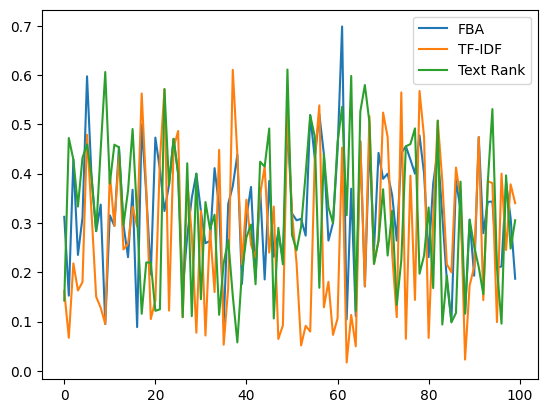

In [16]:

from matplotlib import pyplot as plt

plt.plot(rouge_fba)
plt.plot(rouge_tfidf)
plt.plot(rouge_textRank)
plt.legend(['FBA','TF-IDF','Text Rank'])
plt.show()

In [17]:

avg_tfidf=np.mean(rouge_tfidf)
avg_tfidf

0.2770363133475941

In [18]:

avg_tr=np.mean(rouge_textRank)
avg_tr

0.31625682669317934

In [19]:

news_1="NEW DELHI: Indian iron ore miner NMDC Ltd is in talks with Australia's Hancock Prospecting Pty Ltd for lithium exploration and mining, a source familiar with the matter told Reuters on Tuesday.Countries across the world are racing to secure lithium supplies for rechargeable batteries for future fleets of electric vehicles in the global transition to green energy.India, which found its first reserves of the mineral in February, has also been exploring ways to shore up supplies by acquiring overseas mines.Lithium exploration is at a very nascent stage, but we are talking to Hancock Prospecting for their investments into it, said the source, who didn't want to be named because he is not authorised to talk to media. NMDC shares rose as much as 1.8% Tuesday on the news. The miner did not immediately respond to a request for comment.Separately, NMDC is also working on plans to export low-grade iron ore to China, the source said. The miner could collaborate with another company to process and ship out the ore to China, he said.China is India's biggest iron ore customer, importing around 80% of India's overall shipments.Indian producers of low-grade ores largely depend on foreign markets because most major domestic steel producers use high-grade iron ores.NMDC is also expecting to receive forest clearances by June for diamond mining in the central Indian state of Madhya Pradesh, the source said.The mine produces around 10 carats of diamond per 100 tonnes of Kimberlite processed, according to the details provided by the company on its website."

news_2="Five-time champions Mumbai Indians' class and pedigree will once again be tested when they take on an unpredictable Punjab Kings in a crucial Indian Premier League match in Mohali on May 3.A win will give MI the much-needed push on the points table, while a loss will see them slip further and chart a familiar course like the previous edition. MI had finished 10th and last in the previous edition.he Mumbai team is currently placed seventh with eight points from eight matches and things are not looking great for Rohit Sharma's side.The win against Rajasthan Royals at the Wankhede Stadium on April 30, though, would have instilled a fair bit of confidence in the MI team after it chased down a massive 212 with three balls to spare to earn two valuable points.The win was crafted by Singapore-born Australian cricketer Tim David, who smashed three sixes on the trot in the final over during his 14-ball unbeaten 45 to snatch victory from the jaws of defeat.While there were vital contributions from India's T20 specialist batter Suryakumar Yadav (55), tall Australian all-rounder Cameron Green (44), Ishan Kishan (28) and Tilak Varma (29 not out), none could match the ferocity of David's strokes.The 27-year-old middle-order batter smashed five sixes and two boundaries at a strike rate in excess of 300 as Mumbai Indians won on home turf.A similar commitment would be required against Punjab Kings, who are known to play aggressive cricket, though their biggest drawback is an unreliable top order.Barring Shikhar Dhawan and to an extent his opening partner Prabhsimran Singh, very few PBKS batters have contributed enough to their overall totals, though all that changed in their previous game against Chennai Super Kings at Chepauk on April 30.Set a stiff 200-run target by MS Dhoni's side, the entire top and middle-order came to the party to win a last-ball thriller by four wickets. With Prabhsimran and Dhawan laying a good foundation in powerplay, England all-rounder Liam Livingstone, Sam Curran and wicketkeeper-batter Jitesh Sharma all chipped in to make it a memorable chase.The team, though, will likely have to face the fiery pace of Mumbai Indians' Jofra Archer, who was back in the game against Rajasthan Royals, bowling his quota of overs and taking a wicket as well.MI skipper Rohit's form, though, is the biggest concern for the five-time IPL champions and much would depend on the India captain on Wednesday to shore up his side, after contributing just three runs in the match against the Royals."


summary_fba_1=generate_summaryfba(news_1,1)
pred_summary_tfidf_1=generate_summarytfidf(news_1,1)
pred_summary_textRank_1=generateTextRank(news_1)


summary_fba_2=generate_summaryfba(news_2,1)
pred_summary_tfidf_2=generate_summarytfidf(news_2,1)
pred_summary_textRank_2=generateTextRank(news_2)


In [20]:


print("Actual Text: ",news_1)
print("\n\nSummary by FBA: ",summary_fba_1)
print("\n\nSummary by TFIDF: ",pred_summary_tfidf_1)
print("\n\nSummary by TextRank : ",pred_summary_textRank_1[0])


Actual Text:  NEW DELHI: Indian iron ore miner NMDC Ltd is in talks with Australia's Hancock Prospecting Pty Ltd for lithium exploration and mining, a source familiar with the matter told Reuters on Tuesday.Countries across the world are racing to secure lithium supplies for rechargeable batteries for future fleets of electric vehicles in the global transition to green energy.India, which found its first reserves of the mineral in February, has also been exploring ways to shore up supplies by acquiring overseas mines.Lithium exploration is at a very nascent stage, but we are talking to Hancock Prospecting for their investments into it, said the source, who didn't want to be named because he is not authorised to talk to media. NMDC shares rose as much as 1.8% Tuesday on the news. The miner did not immediately respond to a request for comment.Separately, NMDC is also working on plans to export low-grade iron ore to China, the source said. The miner could collaborate with another company 

In [21]:


print("Actual Text: ",news_2)
print("\n\nSummary by TFIDF: ",pred_summary_tfidf_2)
print("\n\nSummary by TextRank : ",pred_summary_textRank_2[0])


Actual Text:  Five-time champions Mumbai Indians' class and pedigree will once again be tested when they take on an unpredictable Punjab Kings in a crucial Indian Premier League match in Mohali on May 3.A win will give MI the much-needed push on the points table, while a loss will see them slip further and chart a familiar course like the previous edition. MI had finished 10th and last in the previous edition.he Mumbai team is currently placed seventh with eight points from eight matches and things are not looking great for Rohit Sharma's side.The win against Rajasthan Royals at the Wankhede Stadium on April 30, though, would have instilled a fair bit of confidence in the MI team after it chased down a massive 212 with three balls to spare to earn two valuable points.The win was crafted by Singapore-born Australian cricketer Tim David, who smashed three sixes on the trot in the final over during his 14-ball unbeaten 45 to snatch victory from the jaws of defeat.While there were vital co

In [22]:

text='Dr. Abhaya Kumar Sahoo is currently working as an Associate Professor in School of Computer Engineering, KIIT Deemed to be University, Odisha. He has completed his B. Tech, M. Tech and Ph.D. from KIIT Deemed to be University in 2010, 2012 and 2021 respectively. He has received Founder’s Gold Medal and Chancellor’s Gold Medal in M. Tech. He has 8 years teaching experience and 1 year industry experience. His favourite teaching subjects include big data, operating system, web technology, computer organization and database. His area of research includes data analytics, recommender system, data security and data mining. He has published more than 20 research papers in national and international conferences and journals. He guides undergraduate and post graduate students in different project. He has also published more than five book chapters in different reputed books. He is involved in different academic activities such as organizing committee member in international conferences, reviewers in international journals, keynote speaker in workshop and different accreditation activities. He has attended more than thirty different programs such as a faculty development program, seminar and workshop in national and international level. He was Odisha State Student Coordinator in Computer Society of India during 2019-20. He has achieved CSI Young IT Professional award in 2013 and Best Faculty award for good academic performance in 2013 and 2014. He is the life member of CSI, IAENG, CSTA and IET.'


summary_fba=generate_summaryfba(text,3)

print(summary_fba)


His area of research includes data analytics, recommender system, data security and data mining. He has attended more than thirty different programs such as a faculty development program, seminar and workshop in national and international level. He has achieved CSI Young IT Professional award in 2013 and Best Faculty award for good academic performance in 2013 and 2014.


In [23]:

summary2=generate_summarytfidf(text,3)
summary2

'Dr. Abhaya Kumar Sahoo is currently working as an Associate Professor in School of Computer Engineering, KIIT Deemed to be University, Odisha. He is involved in different academic activities such as organizing committee member in international conferences, reviewers in international journals, keynote speaker in workshop and different accreditation activities. He has achieved CSI Young IT Professional award in 2013 and Best Faculty award for good academic performance in 2013 and 2014.'

In [25]:

sum3=generateTextRank(text)

sum3

['He has attended more than thirty different programs such as a faculty development program, seminar and workshop in national and international level.',
 'He has published more than 20 research papers in national and international conferences and journals.',
 'He is involved in different academic activities such as organizing committee member in international conferences, reviewers in international journals, keynote speaker in workshop and different accreditation activities.']